In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Process data: model as three layers

In [2]:
def kmeans(data, k=3, max_iters=100, tol=1e-4):
    data = np.array(data).reshape(-1, 1)
    centroids = data[np.random.choice(len(data), k, replace=False)]
    for _ in range(max_iters):
        labels = np.argmin(np.abs(data - centroids.T), axis=1)
        new_centroids = np.zeros_like(centroids)
        for i in range(k):
            cluster_points = data[labels == i]
            if len(cluster_points) > 0:
                new_centroids[i] = cluster_points.mean()
            else:
                new_centroids[i] = data[np.random.choice(len(data))]
        if np.all(np.abs(new_centroids - centroids) < tol):
            break
        centroids = new_centroids
    return labels

def three_layer_model(tank_temps, prints=False):
    if isinstance(tank_temps, list):
        tank_temps = {
            f'tank{tank}-depth{depth}': tank_temps[tank*4 + depth] for tank in range(3) for depth in range(4)
        }

    # Process layer temperatures
    layer_temps = [tank_temps[key] for key in tank_temps]
    iter_count = 0
    if prints: print(f"Before processing: {layer_temps}")
    while (sorted(layer_temps, reverse=True) != layer_temps and iter_count<20):
        iter_count += 1
        layer_temps = []
        for layer in tank_temps:
            if layer_temps:
                if tank_temps[layer] > layer_temps[-1]:
                    mean = round((layer_temps[-1] + tank_temps[layer]) / 2)
                    layer_temps[-1] = mean
                    layer_temps.append(mean)
                else:
                    layer_temps.append(tank_temps[layer])
            else:
                layer_temps.append(tank_temps[layer])
        for i, layer in enumerate(tank_temps):
            tank_temps[layer] = layer_temps[i]
        if iter_count == 20:
            layer_temps = sorted(layer_temps, reverse=True)
    if prints: print(f"After processing: {layer_temps}")

    # Cluster 10 times and select the clustering with the highest top temperature
    data = layer_temps.copy()
    clustering_runs = []
    for i in range(10):
        labels = kmeans(data, k=3)
        cluster_0 = sorted([data[i] for i in range(len(data)) if labels[i] == 0], reverse=True)
        cluster_1 = sorted([data[i] for i in range(len(data)) if labels[i] == 1], reverse=True)
        cluster_2 = sorted([data[i] for i in range(len(data)) if labels[i] == 2], reverse=True)
        cluster_top = max(cluster_0, cluster_1, cluster_2, key=lambda x: np.mean(x) if len(x)>0 else 0)
        top_temp = sum(cluster_top)/len(cluster_top)
        clustering_runs.append({
            'cluster_0': cluster_0,
            'cluster_1': cluster_1,
            'cluster_2': cluster_2,
            'top_temp': top_temp
        })
    best_run = max(clustering_runs, key=lambda x: x['top_temp'])
    cluster_0 = best_run['cluster_0']
    cluster_1 = best_run['cluster_1']
    cluster_2 = best_run['cluster_2']

    # Dealing with 3 clusters
    if cluster_0 and cluster_1 and cluster_2:
        cluster_top = max(cluster_0, cluster_1, cluster_2, key=lambda x: sum(x)/len(x))
        cluster_bottom = min(cluster_0, cluster_1, cluster_2, key=lambda x: sum(x)/len(x))
        cluster_middle = [
            cluster_x for cluster_x in [cluster_0, cluster_1, cluster_2]
            if cluster_x != cluster_top
            and cluster_x != cluster_bottom
            ][0]
        if prints: print(f"{cluster_top}, {cluster_middle}, {cluster_bottom}")

        thermocline1 = max(1, len(cluster_top))
        thermocline2 = thermocline1 + len(cluster_middle)
        if prints: print(f"Thermocline 1: {thermocline1}/12, thermocline 2: {thermocline2}/12")

        top_temp = round(sum(cluster_top)/len(cluster_top))
        middle_temp = round(sum(cluster_middle)/len(cluster_middle))
        bottom_temp = round(sum(cluster_bottom)/len(cluster_bottom))
        if prints: print(f"{top_temp}({thermocline1}){middle_temp}({thermocline2}){bottom_temp}")
        return top_temp, middle_temp, bottom_temp, thermocline1, thermocline2

    # Dealing with less than 3 clusters
    else:
        if cluster_0 and cluster_2:
            cluster_1 = cluster_2
        elif cluster_1 and cluster_2:
            cluster_0 = cluster_2
        # Two clusters
        if cluster_0 and cluster_1:
            cluster_top = max(cluster_0, cluster_1, key=lambda x: sum(x)/len(x))
            cluster_bottom = min(cluster_0, cluster_1, key=lambda x: sum(x)/len(x))
            thermocline1 = len(cluster_top)
            top_temp = round(sum(cluster_top)/len(cluster_top))
            bottom_temp = round(sum(cluster_bottom)/len(cluster_bottom))
            if prints: print(f"{top_temp}({thermocline1}){bottom_temp}")
            return top_temp, top_temp, bottom_temp, thermocline1, thermocline1
        # Single cluster
        else:
            cluster_top = max(cluster_0, cluster_1, cluster_2, key=lambda x: len(x))
            top_temp = round(sum(cluster_top)/len(cluster_top))
            thermocline1 = 12
            if prints: print(f"{top_temp}({thermocline1})")
            return top_temp, top_temp, top_temp, thermocline1, thermocline1

In [3]:
df = pd.read_csv('storage_data_maple.csv')
display(df)

all_init_t, all_init_m, all_init_b = [],[],[]
all_init_th1, all_init_th2 = [],[]
all_final_t, all_final_m, all_final_b = [],[],[]
all_final_th1, all_final_th2 = [],[]

for row in range(len(df)):
    initial_state = df.iloc[row].to_list()[2:12+2]
    t, m, b, th1, th2 = three_layer_model(initial_state)
    all_init_t.append(t)
    all_init_m.append(m)
    all_init_b.append(b)
    all_init_th1.append(th1*2)
    all_init_th2.append(th2*2)
    # initial_state_simplified = [t]*th1 + [m]*(th2-th1) + [b]*(12-th2)
    # df.iloc[row, 2:12+2] = initial_state_simplified

    final_state = df.iloc[row].to_list()[12+2:]
    t, m, b, th1, th2 = three_layer_model(final_state)
    all_final_t.append(t)
    all_final_m.append(m)
    all_final_b.append(b)
    all_final_th1.append(th1*2)
    all_final_th2.append(th2*2)
    # final_state_simplified = [t]*th1 + [m]*(th2-th1) + [b]*(12-th2)
    # df.iloc[row, 12+2:] = final_state_simplified

df['init_t'] = all_init_t
df['init_m'] = all_init_m
df['init_b'] = all_init_b
df['init_th1'] = all_init_th1
df['init_th2'] = all_init_th2
df['final_t'] = all_final_t
df['final_m'] = all_final_m
df['final_b'] = all_final_b
df['final_th1'] = all_final_th1
df['final_th2'] = all_final_th2
df = df.drop(columns=[x for x in df.columns if 'tank' in x])
display(df)

,time,store_heat_in,tank1-depth1-initial,tank1-depth2-initial,tank1-depth3-initial,tank1-depth4-initial,tank2-depth1-initial,tank2-depth2-initial,tank2-depth3-initial,tank2-depth4-initial,...,tank1-depth3-final,tank1-depth4-final,tank2-depth1-final,tank2-depth2-final,tank2-depth3-final,tank2-depth4-final,tank3-depth1-final,tank3-depth2-final,tank3-depth3-final,tank3-depth4-final
0,1741233600000,32.2,95.1,94.3,93.2,92.9,95.7,92.4,93.5,94.9,...,116.7,116.2,117.0,112.2,109.8,115.6,105.2,94.4,94.4,92.4
1,1741237200000,3.5,120.6,118.5,116.7,116.2,117.0,112.2,109.8,115.6,...,116.4,115.0,117.6,113.8,114.5,117.3,112.3,103.0,97.6,91.1
2,1741240800000,-0.8,121.5,119.4,116.4,115.0,117.6,113.8,114.5,117.3,...,115.3,113.2,117.3,113.6,114.5,117.0,110.9,103.9,98.2,91.1
3,1741244400000,-1.2,120.1,118.0,115.3,113.2,117.3,113.6,114.5,117.0,...,114.8,112.2,117.0,113.3,111.5,116.8,110.4,104.0,98.2,88.9
4,1741248000000,-1.0,119.2,117.5,114.8,112.2,117.0,113.3,111.5,116.8,...,114.5,111.2,116.7,113.1,109.1,116.5,109.8,103.7,98.1,87.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,1743912000000,4.2,134.4,124.3,121.6,125.9,129.0,121.7,126.8,129.6,...,131.1,130.8,128.9,121.6,126.4,129.3,130.6,126.9,128.0,127.7
743,1743915600000,3.9,147.8,138.0,131.1,130.8,128.9,121.6,126.4,129.3,...,132.5,136.3,138.5,130.7,127.5,138.7,129.7,125.8,126.9,126.5
744,1743919200000,-7.7,147.4,136.5,132.5,136.3,138.5,130.7,127.5,138.7,...,123.1,127.1,129.3,122.4,127.4,130.4,132.3,128.1,129.0,129.0
745,1743922800000,0.5,134.6,126.2,123.1,127.1,129.3,122.4,127.4,130.4,...,121.8,126.1,128.9,122.0,127.0,129.9,131.4,127.7,128.8,128.4


,time,store_heat_in,init_t,init_m,init_b,init_th1,init_th2,final_t,final_m,final_b,final_th1,final_th2
0,1741233600000,32.2,94,89,76,16,18,118,111,94,10,18
1,1741237200000,3.5,120,115,97,4,16,120,116,97,4,18
2,1741240800000,-0.8,120,116,97,4,18,119,115,98,4,18
3,1741244400000,-1.2,119,115,98,4,18,118,114,97,4,18
4,1741248000000,-1.0,118,114,97,4,18,118,112,93,4,20
...,...,...,...,...,...,...,...,...,...,...,...,...
742,1743912000000,4.2,134,130,126,2,12,148,138,128,2,4
743,1743915600000,3.9,148,138,128,2,4,147,134,127,2,16
744,1743919200000,-7.7,147,134,127,2,16,135,128,126,2,16
745,1743922800000,0.5,135,128,126,2,14,145,128,126,2,16


# Train regressor

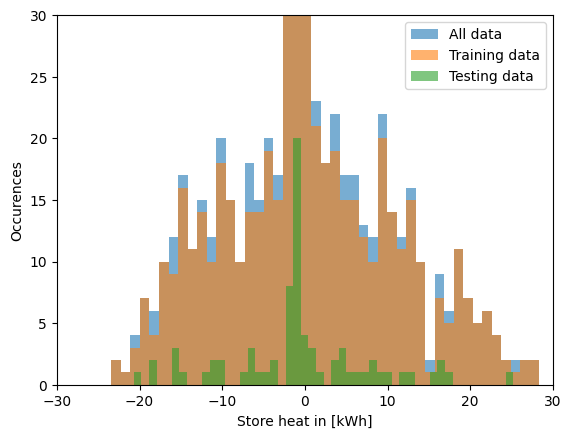

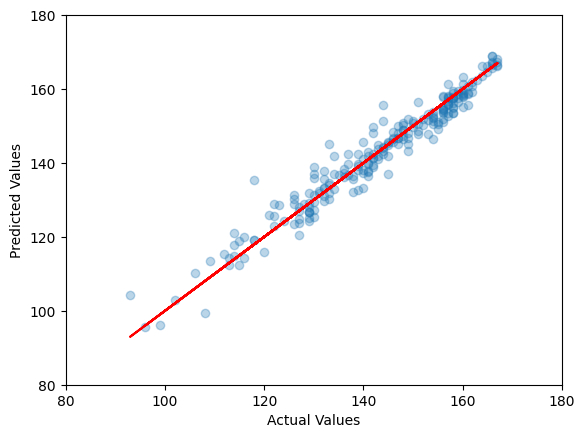

RMSE: 3.3
R-squared: 0.0
Cross-Validation RMSE: 3.5


In [4]:
X = df[[c for c in df.columns if 'init' in c or 'store_heat_in' in c]]
y = df[[c for c in df.columns if 'final' in c]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

plt.hist(df['store_heat_in'], bins=50, label="All data", alpha=0.6)
plt.hist(X_train['store_heat_in'], bins=50, label="Training data", alpha=0.6)
plt.hist(X_test['store_heat_in'], bins=50, label="Testing data", alpha=0.6)
plt.xlabel("Store heat in [kWh]")
plt.ylabel("Occurences")
plt.xlim([-30,30])
plt.ylim([0,30])
plt.legend()
plt.show()

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

plt.scatter(y_test, y_pred_ridge, alpha=0.3)
plt.plot(y_test, y_test, color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.xlim([80,180])
plt.ylim([80,180])
plt.show()

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
ridge_cv_score = cross_val_score(ridge_model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"RMSE: {round(np.sqrt(abs(mse_ridge)),1)}")
print(f"R-squared: {round(r2_ridge,1)}")
print(f"Cross-Validation RMSE: {round(np.sqrt(abs(ridge_cv_score.mean())),1)}")

# Visualize test set

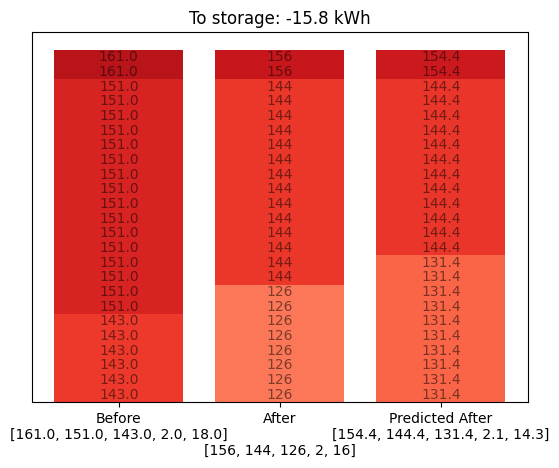

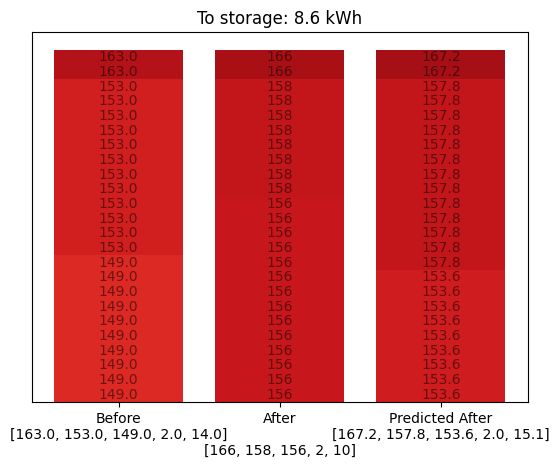

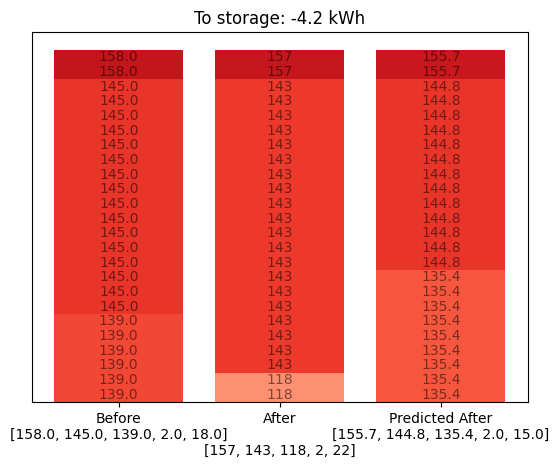

In [5]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

class TankStatePlotter():
    def __init__(self, initial, final, predicted, store_heat_in):
        self.initial = initial
        self.final = final
        self.predicted = predicted
        self.title = f"To storage: {store_heat_in} kWh"
        if len(self.initial)==5:
            self.plot_model()
        else:
            self.plot_12_layers()

    def plot_model(self):
        init_t, init_m, init_b, init_th1, init_th2 = self.initial
        final_t, final_m, final_b, final_th1, final_th2 = self.final
        pred_t, pred_m, pred_b, pred_th1, pred_th2 = self.predicted
        init_th1 = max(1,int(init_th1))
        init_th2 = max(1,int(init_th2))
        final_th1 = max(1,int(final_th1))
        final_th2 = max(1,int(final_th2))
        pred_th1 = max(1,int(pred_th1))
        pred_th2 = max(1,int(pred_th2))

        overall_min = min(init_b, final_b, pred_b)
        overall_max = max(init_t, init_m, init_b)
        norm = Normalize(vmin=80, vmax=180)
        cmap = matplotlib.colormaps['Reds'] 

        # Build top:
        for i in range(init_th1):
            layer_color = cmap(norm(init_t))
            plt.bar([0], 1, bottom=23-i, color=layer_color, width=0.8)
            plt.text(0, 23-i+0.5, f'{init_t}', ha='center', va='center', color='black', alpha=0.5)
        for i in range(final_th1):
            layer_color = cmap(norm(final_t))
            plt.bar([1], 1, bottom=23-i, color=layer_color, width=0.8)
            plt.text(1, 23-i+0.5, f'{final_t}', ha='center', va='center', color='black', alpha=0.5)
        for i in range(pred_th1):
            layer_color = cmap(norm(pred_t))
            plt.bar([2], 1, bottom=23-i, color=layer_color, width=0.8)
            plt.text(2, 23-i+0.5, f'{pred_t}', ha='center', va='center', color='black', alpha=0.5)

        # Build middle:
        for i in range(init_th2-init_th1):
            layer_color = cmap(norm(init_m))
            plt.bar([0], 1, bottom=23-init_th1-i, color=layer_color, width=0.8)
            plt.text(0, 23-init_th1-i+0.5, f'{init_m}', ha='center', va='center', color='black', alpha=0.5)
        for i in range(final_th2-final_th1):
            layer_color = cmap(norm(final_m))
            plt.bar([1], 1, bottom=23-final_th1-i, color=layer_color, width=0.8)
            plt.text(1, 23-final_th1-i+0.5, f'{final_m}', ha='center', va='center', color='black', alpha=0.5)
        for i in range(pred_th2-pred_th1):
            layer_color = cmap(norm(pred_m))
            plt.bar([2], 1, bottom=23-pred_th1-i, color=layer_color, width=0.8)
            plt.text(2, 23-pred_th1-i+0.5, f'{pred_m}', ha='center', va='center', color='black', alpha=0.5)

        # Build bottom:
        for i in range(24-init_th2):
            layer_color = cmap(norm(init_b))
            plt.bar([0], 1, bottom=23-init_th2-i, color=layer_color, width=0.8)
            plt.text(0, 23-init_th2-i+0.5, f'{init_b}', ha='center', va='center', color='black', alpha=0.5)
        for i in range(24-final_th2):
            layer_color = cmap(norm(final_b))
            plt.bar([1], 1, bottom=23-final_th2-i, color=layer_color, width=0.8)
            plt.text(1, 23-final_th2-i+0.5, f'{final_b}', ha='center', va='center', color='black', alpha=0.5)
        for i in range(24-pred_th2):
            layer_color = cmap(norm(pred_b))
            plt.bar([2], 1, bottom=23-pred_th2-i, color=layer_color, width=0.8)
            plt.text(2, 23-pred_th2-i+0.5, f'{pred_b}', ha='center', va='center', color='black', alpha=0.5)

        plt.xticks([0,1,2], [f'Before\n{self.initial}', f'After\n\n{self.final}', f'Predicted After\n{self.predicted}'])
        plt.yticks([])
        plt.title(self.title, fontsize=12)
        plt.show()


    def plot_12_layers(self):
        overall_min = min(min(self.initial), min(self.final), min(self.predicted))
        overall_max = max(max(self.initial), max(self.final), max(self.predicted))
        norm = Normalize(vmin=overall_min, vmax=overall_max)
        cmap = matplotlib.colormaps['Reds'] 

        for i in range(12):
            layer_color = cmap(norm(self.initial[i]))
            plt.bar([0], 1, bottom=11-i, color=layer_color, width=0.8)
            plt.text(0, 11-i+0.5, f'{self.initial[i]}', ha='center', va='center', color='black', alpha=0.5)

            layer_color = cmap(norm(self.final[i]))
            plt.bar([1], 1, bottom=11-i, color=layer_color, width=0.8)
            plt.text(1, 11-i+0.5, f'{self.final[i]}', ha='center', va='center', color='black', alpha=0.5)

            layer_color = cmap(norm(self.predicted[i]))
            plt.bar([3], 1, bottom=11-i, color=layer_color, width=0.8)
            plt.text(3, 11-i+0.5, f'{self.predicted[i]}', ha='center', va='center', color='black', alpha=0.5)

        top_temp, middle_temp, bottom_temp, thermocline1, thermocline2 = model(self.final)
        top_color = cmap(norm(top_temp))
        middle_color = cmap(norm(middle_temp))
        bottom_color = cmap(norm(bottom_temp))
        
        plt.bar([2], height=thermocline1, bottom=12-thermocline1, color=top_color, width=0.8)
        plt.text(2, 12-thermocline1+thermocline1/2, f'{top_temp}', ha='center', va='center', color='black', alpha=0.5)
        plt.bar([2], height=thermocline2-thermocline1, bottom=12-thermocline2, color=middle_color, width=0.8)
        plt.text(2, 12-thermocline2+(thermocline2-thermocline1)/2, f'{middle_temp}', ha='center', va='center', color='black', alpha=0.5)
        plt.bar([2], height=12-thermocline2, bottom=0, color=bottom_color, width=0.8)
        plt.text(2, (12-thermocline2)/2, f'{bottom_temp}', ha='center', va='center', color='black', alpha=0.5)

        top_temp, middle_temp, bottom_temp, thermocline1, thermocline2 = model(self.predicted)
        top_color = cmap(norm(top_temp))
        middle_color = cmap(norm(middle_temp))
        bottom_color = cmap(norm(bottom_temp))
        
        plt.bar([4], height=thermocline1, bottom=12-thermocline1, color=top_color, width=0.8)
        plt.text(4, 12-thermocline1+thermocline1/2, f'{top_temp}', ha='center', va='center', color='black', alpha=0.5)
        plt.bar([4], height=thermocline2-thermocline1, bottom=12-thermocline2, color=middle_color, width=0.8)
        plt.text(4, 12-thermocline2+(thermocline2-thermocline1)/2, f'{middle_temp}', ha='center', va='center', color='black', alpha=0.5)
        plt.bar([4], height=12-thermocline2, bottom=0, color=bottom_color, width=0.8)
        plt.text(4, (12-thermocline2)/2, f'{bottom_temp}', ha='center', va='center', color='black', alpha=0.5)

        plt.xticks([0,1,2,3,4], ['Before', 'After', '-', 'Predicted After', '-'])
        plt.yticks([])
        plt.title(self.title, fontsize=12)
        plt.show()

for i in range(5):
    store_heat_in = X_test.iloc[i].tolist()[0]
    if abs(store_heat_in)<2:
        continue
    initial_temp = [round(x,1) for x in  X_test.iloc[i].tolist()[1:]]
    final_temp = [round(x,1) for x in  y_test.iloc[i].tolist()]
    final_temp_pred = [round(float(x),1) for x in list(y_pred_ridge[i])]
    t = TankStatePlotter(initial_temp, final_temp, final_temp_pred, store_heat_in)